<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod5_4_comparing_cities.ipynb) -->
update colab:

# Statistical inference

We will use the data and model approach we have finalized to infer built-up land cover on the enter time period of 2016 through 2019.

## Fit model

In [1]:
import geemap, ee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import anderson_ksamp

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# define some functions and variables
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)


se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

# create training data
roi = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME','Bagmati')).geometry()

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median().select(se2bands).clip(roi)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2019-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)

vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)

vmu = ee.Number(vmu.get('avg_rad'))
vstd = ee.Number(vstd.get('avg_rad'))

viirs = viirs.subtract(vmu).divide(vstd)

fused = se2.addBands(viirs)

# create and overlay labels to training data
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# fit classifier on entire dataset
new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}
clf = ee.Classifier.smileRandomForest(**new_params).train(data, label, trainingbands)

## Prep new data

In order to predict the data we need to fuse and clean the unseen data just as we did with the training data, but we'll do this for each year.

For the scope of this excercise, we're doing this at an annual level, but you could do this to produce a monthly time series. Try it yourself!

In [2]:
def img_prep(se2collection,
            viirscollection,
            year,
            se2bands,
            roi,
            se2maskfunc,
            scaleFactor):
    se2 = se2collection.filterDate(f"{year}-01-01",f"{year}-12-31").filterBounds(roi).filter(
        ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2maskfunc).median().select(se2bands).clip(roi)
    
    viirs = viirscollection.filterDate(
        f"{year}-01-01",f"{year}-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)

    vmu = viirs.reduceRegion(reducer=ee.Reducer.mean(),scale=scaleFactor)
    vstd = viirs.reduceRegion(reducer=ee.Reducer.stdDev(),scale=scaleFactor)
    vmu = ee.Number(vmu.get('avg_rad'))
    vstd = ee.Number(vstd.get('avg_rad'))
    viirs = viirs.subtract(vmu).divide(vstd)
    return se2.addBands(viirs)

## Run inference

In [3]:
allyears = []

for year in ['2016','2017','2018','2019']:
    img = img_prep(se2collection=ee.ImageCollection('COPERNICUS/S2'),
                    viirscollection=ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG"),
                    year=year,
                    se2bands=se2bands,
                    roi=roi,
                    se2maskfunc=se2mask,
                    scaleFactor=scaleFactor)
    allyears.append(img.classify(clf))

## Histograms

As with {doc}`mod4_2_histograms` we can plot histograms.

In [42]:
allyears_arrs = [img.sample(region=roi, scale=scaleFactor, numPixels=1000) for img in allyears]
allyears_arrs = [np.asarray(arr.reduceColumns(ee.Reducer.toList(1), 
                                              ['classification']).values().get(0).getInfo()) for arr in allyears_arrs]

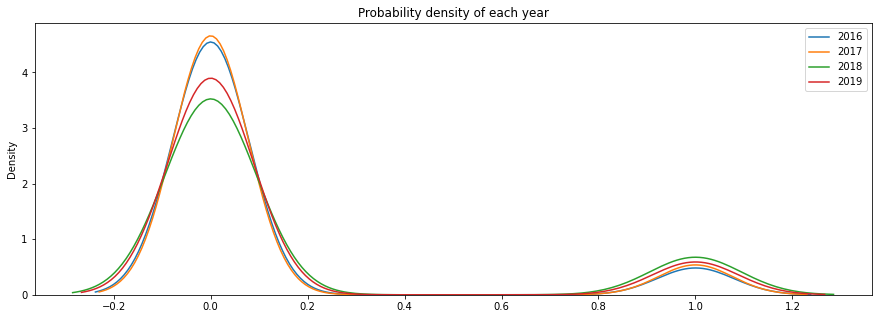

In [48]:
fig, ax = plt.subplots(1, figsize=(15,5))
for arr,yr in zip(allyears_arrs, ['2016','2017','2018','2019']):
    sns.kdeplot(arr.flatten(), label=yr)
plt.legend()
plt.title('Probability density of each year');

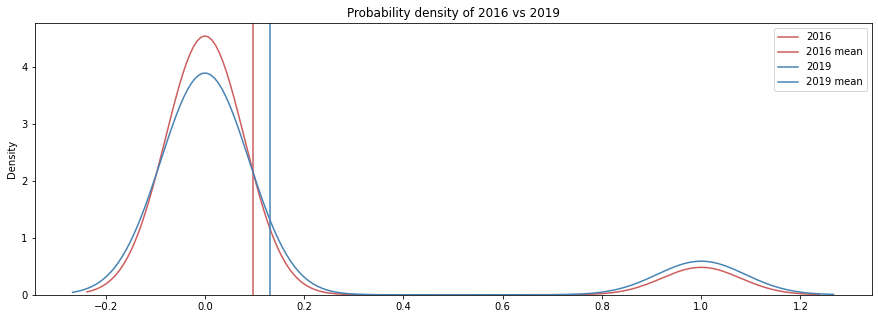

In [57]:
fig, ax = plt.subplots(1, figsize=(15,5))
for arr,yr,c in zip([allyears_arrs[0],allyears_arrs[-1]], ['2016','2019'], ['indianred','steelblue']):
    sns.kdeplot(arr.flatten(), c=c, label=yr)
    ax.axvline(arr.mean(), c=c, label=f"{yr} mean")
plt.legend()
plt.title('Probability density of 2016 vs 2019');

We can see a slight shift in built-up area...but is is statistically signifant? Lets conduct a nonparametric test of variance to find out.

In [65]:
anderson_ksamp([allyears_arrs[0].flatten(), allyears_arrs[-1].flatten()])

Anderson_ksampResult(statistic=4.862300951165673, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.0038881086515751223)

Indeed, using an Anderson-Ksamp test of variance we can reject the null hypothesis that these two distribution are pulled from the same popultion to a significant degree (p<0.01), indicating there is a difference and we can see from the comparison of means, it seems to be that the total built up area has increase.

Let's map the change to see spatial distribution.

In [71]:
# initialize our map
map1 = geemap.Map()
map1.centerObject(roi, 9)
map1.addLayer(allyears[-1].subtract(allyears[0]), {"min":-1.0, "max":1.0}, 'diff')
map1.addLayerControl()
map1

Map(center=[27.87388743003947, 85.41973735675019], controls=(WidgetControl(options=['position'], widget=HBox(c…

## Concluding thoughts

The statistical test of variance indicates that if our classifier and our assumptions are valid, it would indicate that from 2016 to 2019 we saw increase built-up land and therefore economic growth in the Province of Bagmati.

While we do have a truncated region (along the top) from what is visible we clearly see the positive growth (white) along the road network -- something we saw earlier when looking at the nighttime lights scene.